In [1]:
# Installs
%pip install pandas
%pip install scikit-learn
%pip install seaborn
%pip install matplotlib
%pip install q
%pip install joblib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline


sns.set(style="whitegrid", context="notebook")

In [4]:
##  Predicting GCE A-Level Maths grade from prior attainment

# Load the Dataset
file_path = ("Data/synthetic_uk_attainment_10000_clean_1.csv")
df = pd.read_csv(file_path) 

# Quick check 
print(df.head()) 
print(df.info()) 
print(df.isna().sum())

    ref_id  SATS_score  GCSE_grade GCE_AS_grade Alevel_Maths_grade
0  1002670         120           6            A                  A
1  1004752         108           5            B                  B
2  1002953         105           7            B                  B
3  1007545          93           4            D                  D
4  1005538         113           6            A                  A
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ref_id              10000 non-null  int64 
 1   SATS_score          10000 non-null  int64 
 2   GCSE_grade          10000 non-null  int64 
 3   GCE_AS_grade        10000 non-null  object
 4   Alevel_Maths_grade  10000 non-null  object
dtypes: int64(3), object(2)
memory usage: 390.8+ KB
None
ref_id                0
SATS_score            0
GCSE_grade            0
GCE_AS_grade          0
Al

In [5]:
# ref_id               int
# SATS_score           int
# GCSE_grade           int (9-1)
# GCE_AS_grade         object (A, B, C, D, E, U)
# GCE_A_grade          object (A*, A, B, C, D, E, U)
# Alevel_Maths_grade    object (A*, A, B, C, D, E, U)

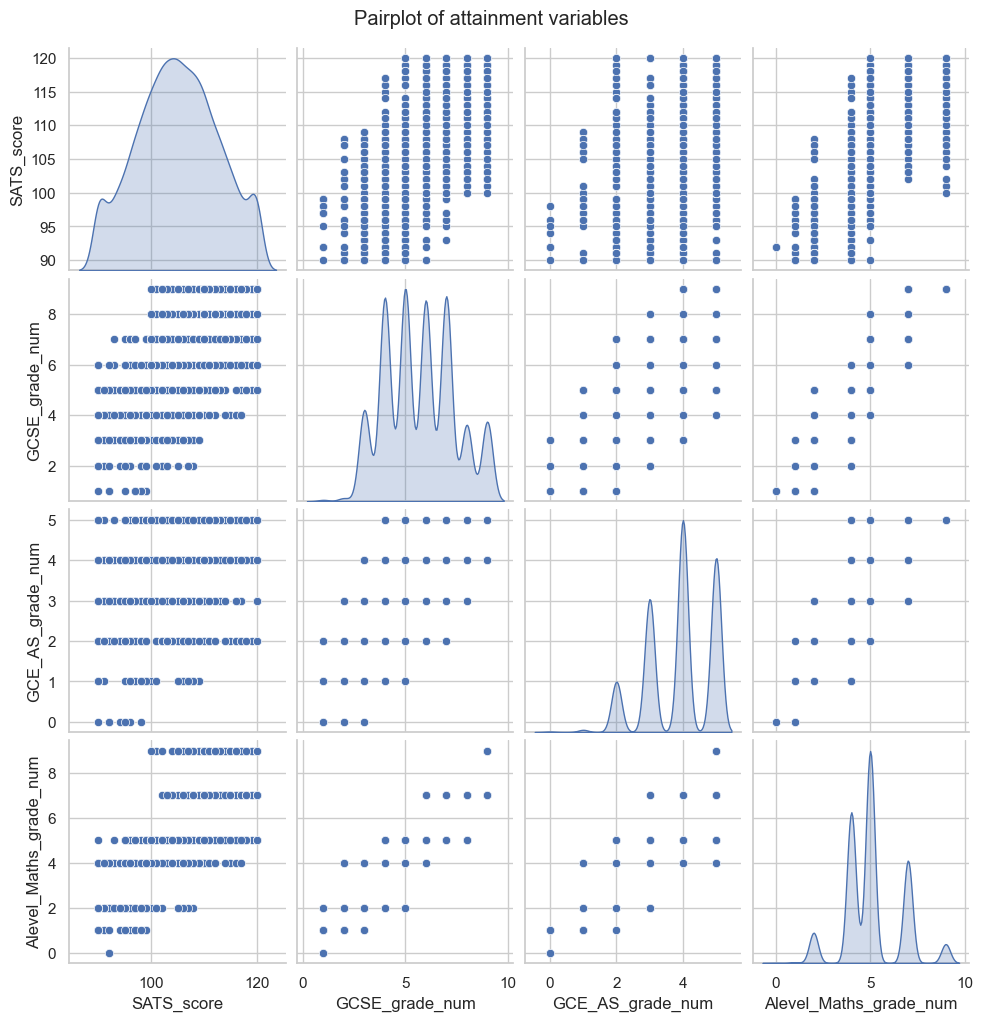

In [6]:
# ---------------------------------------------------------
# 1. Grade mappings
# ---------------------------------------------------------
# AS-level numeric mapping
AS_TO_NUM = {
    'U': 0,
    'E': 1,
    'D': 2,
    'C': 3,
    'B': 4,
    'A': 5
}

# A-level numeric mapping with ranges
ALEVEL_MATHS_TO_RANGE = {
    'U': 0,  
    'E': 1,  
    'D': range(2, 4),   # 2, 3
    'C': 4,  
    'B': range(5, 7),   # 5, 6
    'A': range(7, 9),   # 7, 8
    'A*': 9,  
}


def range_to_value(r):
    if isinstance(r, range):
        return r.start
    return r


ALEVEL_MATHS_TO_NUM = {
    grade: range_to_value(rng)
    for grade, rng in ALEVEL_MATHS_TO_RANGE.items()
}

NUM_TO_AS = {v: k for k, v in AS_TO_NUM.items()}
NUM_TO_ALEVEL_MATHS = {v: k for k, v in ALEVEL_MATHS_TO_NUM.items()}

# ---------------------------------------------------------
# 2. Validate expected columns
# ---------------------------------------------------------

expected_cols = [
    "SATS_score",
    "GCSE_grade",
    "GCE_AS_grade",
    "Alevel_Maths_grade"
]

missing = [c for c in expected_cols if c not in df.columns]
data = df.copy()


if missing:
    raise KeyError(f"Your dataframe is missing required columns: {missing}")

# ---------------------------------------------------------
# 3. Create working copy and clean string grades
# ---------------------------------------------------------

# Create working copy AFTER validation
data = df.copy()

data["GCE_AS_grade"] = (
    data["GCE_AS_grade"]
    .astype(str)
    .str.strip()
    .str.upper()
)

data["Alevel_Maths_grade"] = (
    data["Alevel_Maths_grade"]
    .astype(str)
    .str.strip()
    .str.upper()
)

# ---------------------------------------------------------
# 4. Helper: safe encoder with warnings
# ---------------------------------------------------------

def encode_grade_series(s, mapping, col_name):
    unknown = set(s.unique()) - set(mapping.keys())
    if unknown:
        print(f"Warning: {col_name} has unknown grades: {unknown}")
    return s.map(mapping)

# ---------------------------------------------------------
# 5. Encode numeric columns
# ---------------------------------------------------------

# GCSE numeric
data["GCSE_grade_num"] = data["GCSE_grade"].astype(int)

# Encode AS
data["GCE_AS_grade_num"] = encode_grade_series(
    data["GCE_AS_grade"], AS_TO_NUM, "GCE_AS_grade"
)

# Encode A-level Maths
data["Alevel_Maths_grade_num"] = encode_grade_series(
    data["Alevel_Maths_grade"], ALEVEL_MATHS_TO_NUM, "Alevel_Maths_grade"
)

# ---------------------------------------------------------
# 6. EDA pairplot
# ---------------------------------------------------------

eda_cols = [
    "SATS_score",
    "GCSE_grade_num",
    "GCE_AS_grade_num",
    "Alevel_Maths_grade_num",
]

sns.pairplot(data[eda_cols], diag_kind="kde")
plt.suptitle("Pairplot of attainment variables", y=1.02)
plt.show()


In [7]:
#data exploration
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ref_id              10000 non-null  int64 
 1   SATS_score          10000 non-null  int64 
 2   GCSE_grade          10000 non-null  int64 
 3   GCE_AS_grade        10000 non-null  object
 4   Alevel_Maths_grade  10000 non-null  object
dtypes: int64(3), object(2)
memory usage: 390.8+ KB


In [8]:
# Basic statistics for numeric columns
df.describe(include="all")

,ref_id,SATS_score,GCSE_grade,GCE_AS_grade,Alevel_Maths_grade
count,1.000000e+04,10000.000000,10000.000000,10000,10000
unique,NaN,NaN,NaN,6,7
top,NaN,NaN,NaN,B,B
freq,NaN,NaN,NaN,3702,4113
mean,1.005000e+06,104.999700,5.706000,NaN,NaN
std,2.886896e+03,7.614939,1.689275,NaN,NaN
min,1.000000e+06,90.000000,1.000000,NaN,NaN
25%,1.002500e+06,100.000000,4.000000,NaN,NaN
50%,1.005000e+06,105.000000,6.000000,NaN,NaN
75%,1.007499e+06,110.000000,7.000000,NaN,NaN


In [9]:
#Understand structure and grade distributions
# Basic stats for SATS
print(df["SATS_score"].describe())

# Unique values / distributions of grades
print("\nGCSE_grade distribution:")
print(df["GCSE_grade"].value_counts().sort_index())

print("\nGCE_AS_grade distribution:")
print(df["GCE_AS_grade"].value_counts().sort_index())

print("\nAlevel_Maths_grade distribution:")
print(df["Alevel_Maths_grade"].value_counts().sort_index())


count    10000.000000
mean       104.999700
std          7.614939
min         90.000000
25%        100.000000
50%        105.000000
75%        110.000000
max        120.000000
Name: SATS_score, dtype: float64

GCSE_grade distribution:
GCSE_grade
1      12
2      28
3     850
4    1897
5    1981
6    1870
7    1909
8     711
9     742
Name: count, dtype: int64

GCE_AS_grade distribution:
GCE_AS_grade
A    3044
B    3702
C    2326
D     881
E      39
U       8
Name: count, dtype: int64

Alevel_Maths_grade distribution:
Alevel_Maths_grade
A     1990
A*     367
B     4113
C     2925
D      588
E       15
U        2
Name: count, dtype: int64


In [10]:
# Implement encoders
# # Ordered mapping for A-level style grades
grade_order = ["U", "E", "D", "C", "B", "A", "A*"]
grade_to_num = {g: i for i, g in enumerate(grade_order)}

def encode_grade_series(s, mapping, col_name):
    """Safely encode a grade column using the provided mapping."""
    unknown = set(s.unique()) - set(mapping.keys())
    if unknown:
        print(f"Warning: {col_name} has unknown grades: {unknown}")
    return s.map(mapping)

# Create a working copy
data = df.copy()

# GCSE: cast to integer (it’s already numeric in your file)
data["GCSE_grade_num"] = data["GCSE_grade"].astype(int)

# Encode AS, A, and A Maths grades
def encode_grade_series(s, mapping, col_name):
    unknown = set(s.unique()) - set(mapping.keys())
    if unknown:
        print(f"Warning: {col_name} has unknown grades: {unknown}")
    return s.map(mapping)

data = df.copy()

# GCSE: already numeric, just ensure int
data["GCSE_grade_num"] = data["GCSE_grade"].astype(int)

# Encode AS grades
data["GCE_AS_grade_num"] = encode_grade_series(
    data["GCE_AS_grade"],
    AS_TO_NUM,
    "GCE_AS_grade",
)

# Encode A-level Maths grades
data["Alevel_Maths_grade_num"] = encode_grade_series(
    data["Alevel_Maths_grade"],
    ALEVEL_MATHS_TO_NUM,
    "Alevel_Maths_grade",
)


# Check encodings
print(
    data[
        [
            "GCSE_grade",
            "GCSE_grade_num",
            "GCE_AS_grade",
            "GCE_AS_grade_num",
            "Alevel_Maths_grade",
            "Alevel_Maths_grade_num",
        ]
    ].head()
)


   GCSE_grade  GCSE_grade_num GCE_AS_grade  GCE_AS_grade_num  \
0           6               6            A                 5   
1           5               5            B                 4   
2           7               7            B                 4   
3           4               4            D                 2   
4           6               6            A                 5   

  Alevel_Maths_grade  Alevel_Maths_grade_num  
0                  A                       7  
1                  B                       5  
2                  B                       5  
3                  D                       2  
4                  A                       7  


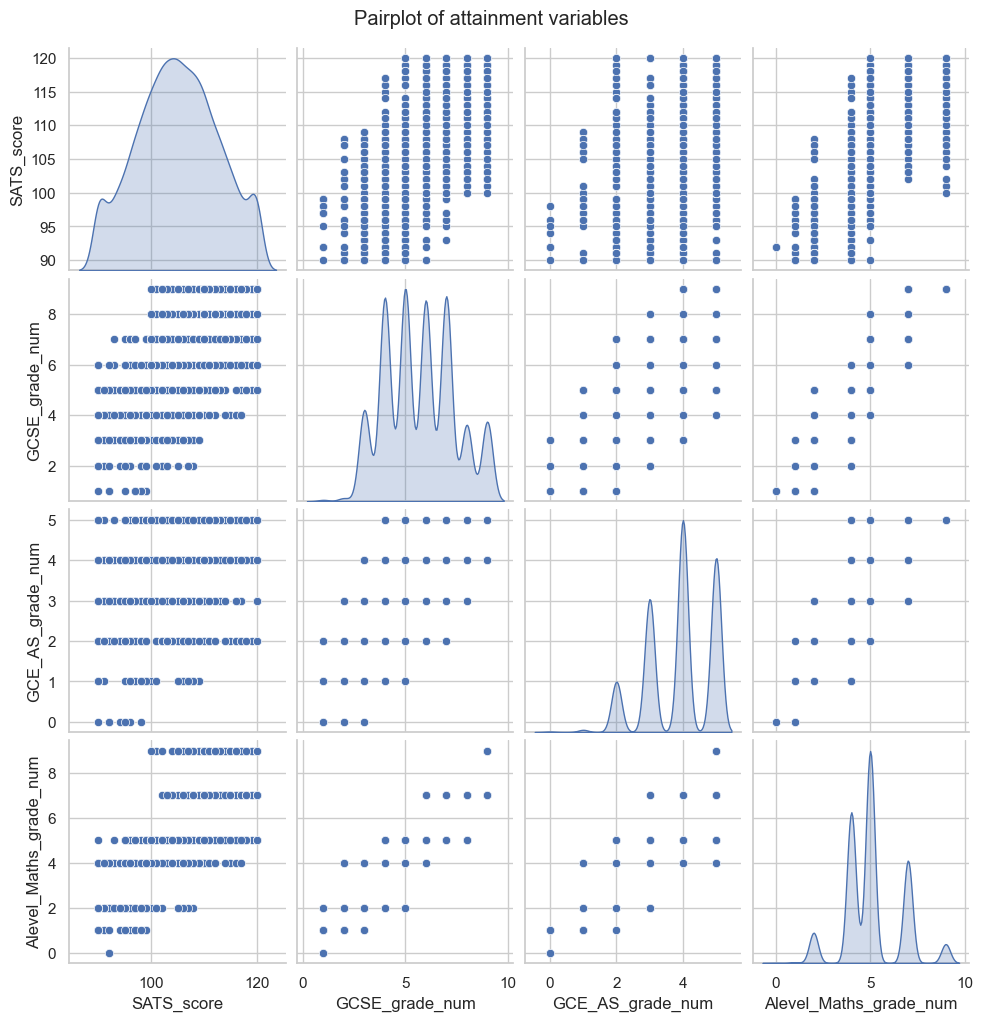

In [11]:
#Exploratory data analysis (EDA)
# Pairplot of key variables
# Select columns for EDA
eda_cols = [
    "SATS_score",
    "GCSE_grade_num",
    "GCE_AS_grade_num",
    "Alevel_Maths_grade_num",
]

sns.pairplot(data[eda_cols], diag_kind="kde")
plt.suptitle("Pairplot of attainment variables", y=1.02)
plt.show()

In [12]:
# Train–test split with stratification
# Define features and target
feature_cols = [
    "SATS_score",
    "GCSE_grade_num",
    "GCE_AS_grade_num",
    ]
target_col = "Alevel_Maths_grade_num"

X = data[feature_cols]
y = data[target_col]

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train target distribution:\n", y_train.value_counts(normalize=True).sort_index())
print("Test target distribution:\n", y_test.value_counts(normalize=True).sort_index())


Train shape: (8000, 3) Test shape: (2000, 3)
Train target distribution:
 Alevel_Maths_grade_num
0    0.00025
1    0.00150
2    0.05875
4    0.29250
5    0.41125
7    0.19900
9    0.03675
Name: proportion, dtype: float64
Test target distribution:
 Alevel_Maths_grade_num
1    0.0015
2    0.0590
4    0.2925
5    0.4115
7    0.1990
9    0.0365
Name: proportion, dtype: float64


In [13]:
# Build a logistic regression pipeline
#StandardScaler: scale features
# LogisticRegression: multiclass classifier with increased max_iter for convergence.

log_reg_clf = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        (
            "logreg",
            LogisticRegression(
                solver="lbfgs",
                max_iter=2000
            ),
        ),
    ]
)

# Train
log_reg_clf.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('logreg', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not w

In [14]:
# Evaluate the model

# Predictions and classification report
from sklearn.metrics import accuracy_score

y_pred = log_reg_clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report (numeric grades):")
print(classification_report(y_test, y_pred))


Accuracy: 0.991

Classification report (numeric grades):
              precision    recall  f1-score   support

           1       1.00      0.33      0.50         3
           2       0.97      0.97      0.97       118
           4       0.99      1.00      1.00       585
           5       1.00      1.00      1.00       823
           7       0.99      0.98      0.99       398
           9       0.92      1.00      0.96        73

    accuracy                           0.99      2000
   macro avg       0.98      0.88      0.90      2000
weighted avg       0.99      0.99      0.99      2000



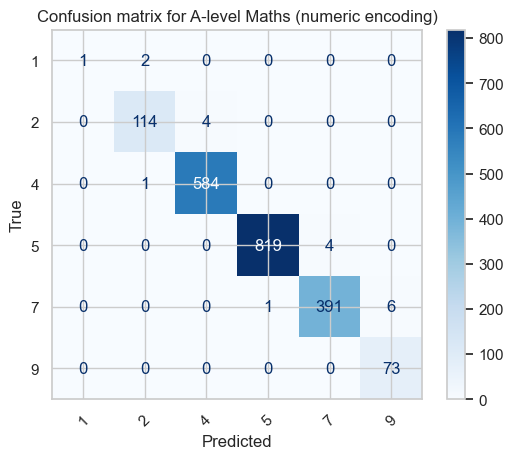

In [15]:
#Confusion matrix (numeric)
import numpy as np

# Determine which classes actually appear
present_classes = np.unique(np.concatenate([y_test, y_pred]))

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=present_classes
)

disp.plot(
    cmap="Blues",
    xticks_rotation=45,
)
plt.title("Confusion matrix for A-level Maths (numeric encoding)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Classification report (grade labels):
              precision    recall  f1-score   support

           A       0.99      0.98      0.99       398
          A*       0.92      1.00      0.96        73
           B       1.00      1.00      1.00       823
           C       0.99      1.00      1.00       585
           D       0.97      0.97      0.97       118
           E       1.00      0.33      0.50         3

    accuracy                           0.99      2000
   macro avg       0.98      0.88      0.90      2000
weighted avg       0.99      0.99      0.99      2000



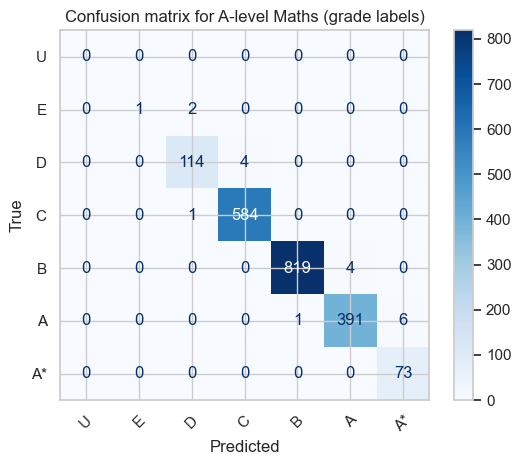

In [16]:
# map numeric back to grade labels for interpretability
# Reverse mapping using grade_ranges
def num_to_grade(v):
    for grade, rng in ALEVEL_MATHS_TO_RANGE.items():
        if isinstance(rng, range):
            if v in rng:
                return grade
        else:
            if v == rng:
                return grade
    return None


# Convert numeric predictions back to grade labels
y_test_labels = y_test.map(num_to_grade)
y_pred_labels = pd.Series(y_pred, index=y_test.index).map(num_to_grade)

print("\nClassification report (grade labels):")
print(classification_report(y_test_labels, y_pred_labels))

cm_labels = confusion_matrix(y_test_labels, y_pred_labels, labels=grade_order)

disp_labels = ConfusionMatrixDisplay(
    confusion_matrix=cm_labels,
    display_labels=grade_order,
)
disp_labels.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion matrix for A-level Maths (grade labels)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


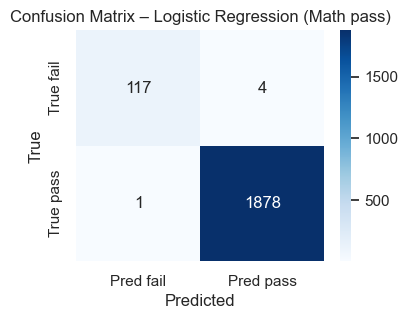

In [17]:
#Confusion matrix + heatmap
# Convert numeric grades to binary pass/fail
# Fail = 0, Pass = 1
# Using your grade_to_num mapping:
# U=0, E=1, D=2-3, C=4, B=5-6, A=7-8, A*=9

y_test_binary = (y_test >= 3).astype(int)
y_pred_binary = (y_pred >= 3).astype(int)

# Confusion matrix (binary)
cm = confusion_matrix(y_test_binary, y_pred_binary)

plt.figure(figsize=(4,3))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Pred fail', 'Pred pass'],
    yticklabels=['True fail', 'True pass']
)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('Confusion Matrix – Logistic Regression (Math pass)')
plt.show()


In [18]:
# Persist the trained model with joblib
model_path = "uk_attainment_logreg_math.pkl"
joblib.dump(log_reg_clf, model_path)

print(f"Model saved to {model_path}")

Model saved to uk_attainment_logreg_math.pkl


In [20]:
#Load and use later (deployment-style usage)
# Later, in a different script / environment:
loaded_model = joblib.load(model_path)

# Example: predict for some new students
#new_students = pd.DataFrame(
#    {
#        "SATS_score": [105, 115],
#        "GCSE_grade_num": [6, 8],
#        "GCE_AS_grade_num": [4, 5],  # B, A
#    }
#)

new_students = pd.DataFrame(
    {
        "SATS_score": [105],
        "GCSE_grade_num": [6],
        "GCE_AS_grade_num": [4],  # B
    }
)

pred_nums = loaded_model.predict(new_students)
pred_grades = pd.Series(pred_nums).map(num_to_grade)

print("Predicted A-level Maths grades:", list(pred_grades))

Predicted A-level Maths grades: ['B']
